# HM model

## method - 1

In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

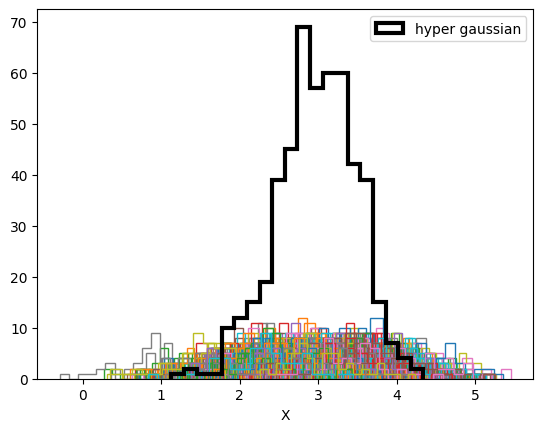

In [2]:
def generate_data(mean, scale, size):
    """
    Function to generate a Gaussian distribution with specified mean, scale and size. 
    """
    return np.random.normal(loc=mean, scale=scale, size=size)

# True parameters for the parent + child Gaussian distribution

true_parent_mean = 3.0 # hyperparameter
true_parent_scale = .5 # hyperparameter

true_child_scale = 0.5

N_obs = 500
size_child = 50

# Hypothesis for parent gaussian 
parent_gaussian = generate_data(true_parent_mean, true_parent_scale, size=N_obs)

# Add scatter on the child mean because the data for a signal is signal + noise
err_on_mean_child = np.expand_dims(np.random.randn(N_obs)/10, axis=1)
child_gaussian = np.random.normal(loc=parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

for i in range(N_obs):
    plt.hist(child_gaussian[i], fill=False, histtype='step', bins=20)
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian', bins=20)
plt.xlabel("X")
plt.legend()

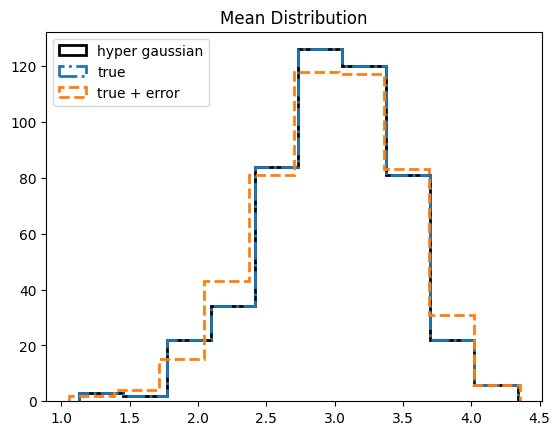

In [3]:
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=2, label='hyper gaussian')
plt.hist(parent_gaussian[:, np.newaxis], histtype='step', fill=False, label='true', linestyle='-.', linewidth=2)
plt.hist(parent_gaussian[:, np.newaxis] + err_on_mean_child, fill=False, histtype='step', label='true + error', linestyle='--', linewidth=2)
plt.title("Mean Distribution")
plt.legend()

In [4]:
def log_likelihood(params):
    parent_mean, parent_scale = params

    weights = np.log(np.sum(
                (2 * np.pi * true_child_scale**2)**(-0.5) * \
                np.exp(-(child_gaussian - np.expand_dims(child_gaussian.mean(axis=1), axis=1))**2 / \
                (2 * true_child_scale**2)),
                axis=1))
    chi_sq = ((child_gaussian.mean(axis=1) - parent_mean)**2 / (2 * parent_scale**2))
    
    return - 0.5 * N_obs * np.log(2 * np.pi * parent_scale**2 * size_child**2) - np.sum(chi_sq + weights)

In [5]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([true_parent_mean, true_parent_scale]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial)
mu_ml, sigma_ml = soln.x
    
print("Maximum likelihood estimates:")
print("mu = {0:.3f}".format(mu_ml))
print("sigma = {0:.3f}".format(sigma_ml))

Maximum likelihood estimates:
mu = 2.978
sigma = 0.525


In [6]:
def log_prior(params):
    parent_mean, parent_scale = params
    # Flat priors 
    if (0 < parent_mean < 5 and 
        0 < parent_scale < 5):
        return 0.0
    return -np.inf

def log_probability(params):
    log_prior_val = log_prior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [7]:
import emcee

pos = soln.x + 1e-6 * np.random.randn(50, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)
sampler.run_mcmc(pos, 2000, progress=True)

100%|██████████| 2000/2000 [00:15<00:00, 130.80it/s]


State([[3.03139038 0.53061304]
 [2.97121917 0.55613078]
 [3.03669089 0.54748648]
 [3.00514034 0.52004039]
 [2.97617195 0.51942581]
 [3.01015984 0.52934326]
 [2.96948859 0.5128386 ]
 [3.00736115 0.53034041]
 [2.91809805 0.52258213]
 [2.99119047 0.52484961]
 [2.95147596 0.52053778]
 [2.96059909 0.55814757]
 [2.98181667 0.52023638]
 [3.00127932 0.54455543]
 [2.9856984  0.52734411]
 [2.97567332 0.55196781]
 [2.98323128 0.50630396]
 [2.99952169 0.52620638]
 [2.95470516 0.56887272]
 [2.97236376 0.52172042]
 [2.9730584  0.52636904]
 [2.95777667 0.52250908]
 [2.98810248 0.54161689]
 [2.92896767 0.51678697]
 [2.97195197 0.50901832]
 [2.98568198 0.51266836]
 [2.96838113 0.52171444]
 [2.98110219 0.51642906]
 [2.95137737 0.51110231]
 [3.04182848 0.55308511]
 [2.97513289 0.53367383]
 [2.94566717 0.54620434]
 [2.99233751 0.51904058]
 [2.96703892 0.53929708]
 [2.96965121 0.5149908 ]
 [2.97063516 0.5085735 ]
 [2.97493057 0.54625054]
 [2.96798027 0.52812259]
 [2.96988831 0.52894199]
 [2.95708009 0.5317

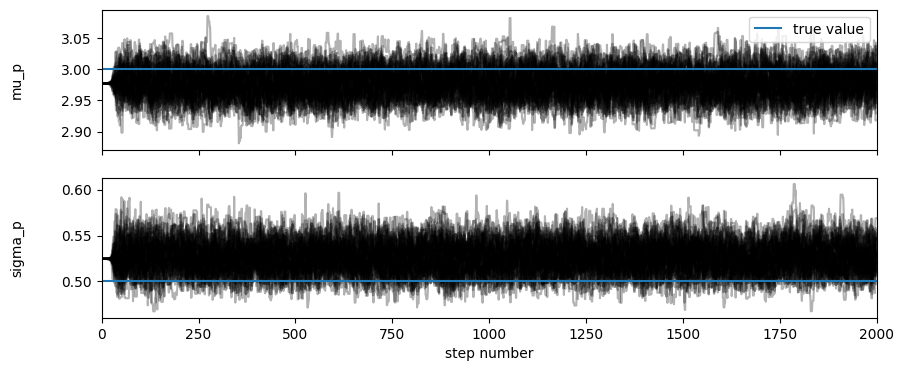

In [8]:
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["mu_p", "sigma_p"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[0].hlines(true_parent_mean, 0, len(samples), label="true value")
axes[1].hlines(true_parent_scale, 0, len(samples))
axes[-1].set_xlabel("step number")
axes[0].legend()

In [9]:
tau = sampler.get_autocorr_time()
print(tau)

[26.45652759 25.72169037]


In [10]:
flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
print(flat_samples.shape)

(6500, 2)


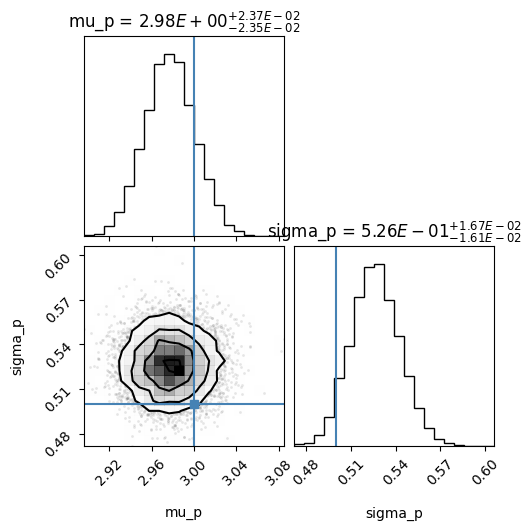

In [11]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_parent_mean, true_parent_scale], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

## method - 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# True parameters for the parent + child Gaussian distribution

true_parent_mean = 3.0 # hyperparameter
true_parent_scale = .5 # hyperparameter

true_child_scale = 0.5

N_obs = 5
size_child = 3

# Hypothesis for parent gaussian 
parent_gaussian = np.random.normal(loc=true_parent_mean, scale=true_parent_scale, size=N_obs)

# Add scatter on the child mean because the data for a signal is signal + noise
err_on_mean_child = np.expand_dims(np.random.randn(N_obs)/10, axis=1)
child_gaussian = np.random.normal(loc=parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))
"""
for i in range(N_obs):
    plt.hist(child_gaussian[i], fill=False, histtype='step', bins=20)
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian', bins=20)
plt.xlabel("X")
plt.legend()"""

'\nfor i in range(N_obs):\n    plt.hist(child_gaussian[i], fill=False, histtype=\'step\', bins=20)\nplt.hist(parent_gaussian, fill=False, histtype=\'step\', color=\'black\',linewidth=3, label=\'hyper gaussian\', bins=20)\nplt.xlabel("X")\nplt.legend()'

In [3]:
posterior_child = lambda child_mean, X_ji : (2 * np.pi * true_child_scale**2)**(-0.5) * np.exp(-(X_ji - child_mean)**2 / (2 * true_child_scale**2))

posterior_parent = lambda parent_mean, parent_scale, child_mean: (2 * np.pi * parent_scale**2)**(-0.5) * np.exp(-(parent_mean - child_mean)**2 / (2 * parent_scale**2))

def log_likelihood(params, X_ji):
    parent_mean, parent_scale, child_mean = params
    model = np.sum(posterior_parent(parent_mean, parent_scale, child_mean), np.sum(posterior_child(child_mean, X_ji), axis=1))
    return np.log(np.product(model))

In [1]:
import scipy.stats as st
def log_prior(params):
    parent_mean, parent_scale, *child_means = params
    child_means_priors = [st.norm.logpdf(child_mean, loc=parent_mean, scale=parent_scale) for child_mean in child_means]
    child_mean_range = (0,10)
    if (all(child_mean_range[0] < child_mean < child_mean_range[1] for child_mean in child_means_priors) and
        0 < parent_mean < 5 and 
        0 < parent_scale < 1):
        return 0.0
    return -np.inf

def log_probability(params, X_ji):
    log_prior_val = log_prior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params, X_ji)

In [18]:
import emcee

pos = soln.x + 1e-6 * np.random.randn(50, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)
sampler.run_mcmc(pos, 8000, progress=True)

100%|██████████| 8000/8000 [01:03<00:00, 126.97it/s]


State([[3.02051749 0.5043101 ]
 [2.98956822 0.5051    ]
 [2.98074685 0.50695102]
 [3.00013478 0.52019009]
 [2.98609483 0.49960984]
 [2.98197676 0.52428852]
 [2.99884363 0.50535578]
 [3.00443097 0.5195152 ]
 [3.00751734 0.51670799]
 [3.04625188 0.49325019]
 [3.00369963 0.50083587]
 [3.02294379 0.51660265]
 [3.03578823 0.53398377]
 [3.04476289 0.52874634]
 [3.0153969  0.49710603]
 [3.00544153 0.53725315]
 [2.99866608 0.51383733]
 [3.00750216 0.49670487]
 [3.00497342 0.48906877]
 [2.98097493 0.48068493]
 [3.01115459 0.4859719 ]
 [2.99814428 0.50454094]
 [2.99937925 0.50921589]
 [3.01006207 0.50548214]
 [3.01607882 0.52003283]
 [2.99330726 0.51803891]
 [3.01607086 0.485248  ]
 [3.00701764 0.48927409]
 [3.0053652  0.50094902]
 [3.01806419 0.52213092]
 [3.00449446 0.48839381]
 [3.00656452 0.51123608]
 [3.00965277 0.48173648]
 [3.042819   0.51258154]
 [3.01742031 0.51337495]
 [2.96528152 0.5171512 ]
 [2.98709428 0.52244125]
 [3.04583131 0.52725085]
 [3.01285368 0.52092548]
 [3.01247426 0.4771

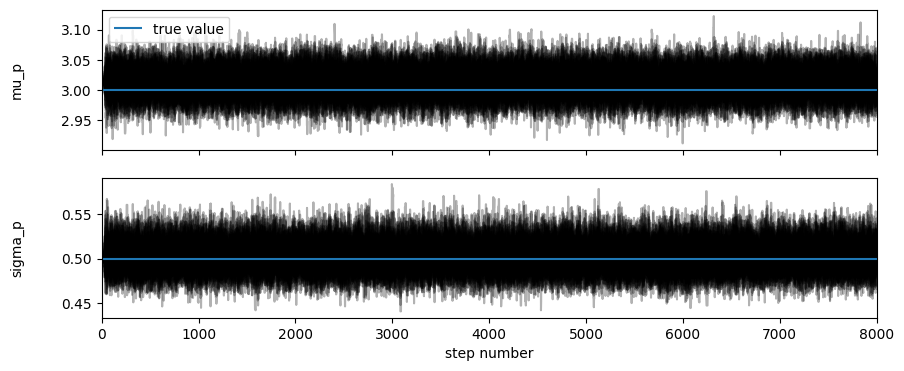

In [19]:
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["mu_p", "sigma_p"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[0].hlines(true_parent_mean, 0, len(samples), label="true value")
axes[1].hlines(true_parent_scale, 0, len(samples))
axes[-1].set_xlabel("step number")
axes[0].legend()

In [20]:
tau = sampler.get_autocorr_time()
print(tau)

[31.17864383 31.28798031]


In [21]:
flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
print(flat_samples.shape)

(26500, 2)


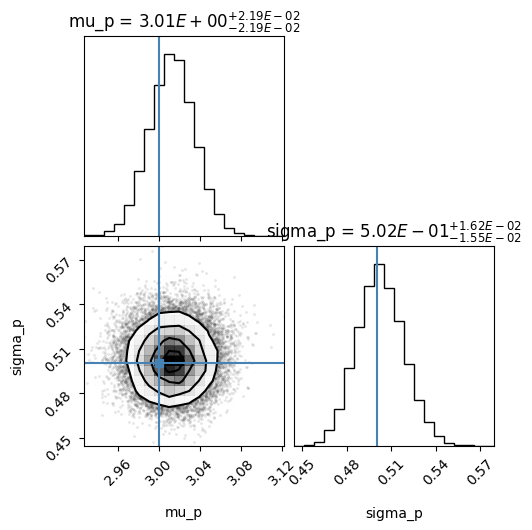

In [22]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_parent_mean, true_parent_scale], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

# ADDITION OF SELECTION EFFECTS ?

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

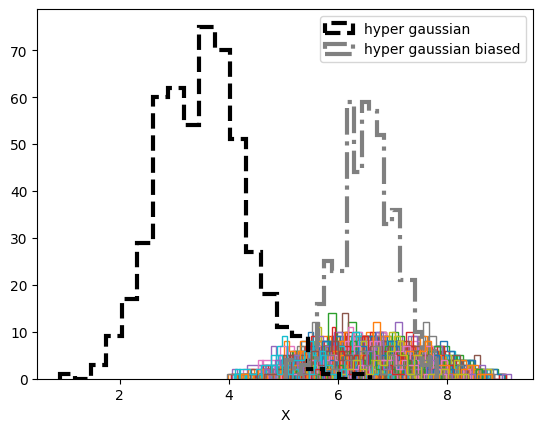

In [24]:
# True parameters for the parent + child Gaussian distribution

true_parent_mean = 3.5 # hyperparameter
true_parent_scale = .8 # hyperparameter

true_parent_mean_bias = true_parent_mean + 3# hyperparameter
true_parent_scale_bias = .5 # hyperparameter

true_child_scale = 0.5
detection_scale = 0.3

N_obs = 500
size_child = 50

# Hypothesis for parent gaussian
parent_gaussian = np.random.normal(loc=true_parent_mean, scale=true_parent_scale, size=N_obs)
parent_gaussian_bias = np.random.normal(loc=true_parent_mean_bias, scale=true_parent_scale_bias, size=N_obs)

# Add scatter on the child mean because the data for a signal is signal + noise
err_on_mean_child = np.expand_dims(np.random.randn(N_obs)/10, axis=1)
child_gaussian = np.random.normal(loc=parent_gaussian_bias[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

for i in range(N_obs):
    plt.hist(child_gaussian[i], fill=False, histtype='step', bins=20)
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian', bins=20, linestyle='--')
plt.hist(parent_gaussian_bias, fill=False, histtype='step', color='grey',linewidth=3, label='hyper gaussian biased', bins=20, linestyle='-.')
#plt.plot(parent_gaussian)
plt.xlabel("X")
plt.legend()

In [25]:
posterior_child = lambda : (2 * np.pi * true_child_scale**2)**(-0.5) * np.exp(-(child_gaussian - np.expand_dims(child_gaussian.mean(axis=1), axis=1))**2 / (2 * true_child_scale**2))
model = lambda parent_mean, parent_scale, parent_scale_bias : \
                                (2 * np.pi * parent_scale**2)**(-0.5) * np.exp(-(child_gaussian.mean(axis=1) - parent_mean)**2 / (2 * parent_scale**2)) * \
                                (2 * np.pi * parent_scale_bias**2)**(-0.5) * np.exp(-(child_gaussian.mean(axis=1) - parent_mean)**2 / (2 * parent_scale_bias**2)) * \
                                size_child**-1 * np.sum(posterior_child(), axis=1) 

def log_likelihood(params):
    parent_mean, parent_scale, parent_scale_bias = params
    return np.log(np.product(model(parent_mean, parent_scale, parent_scale_bias)))

In [26]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([true_parent_mean, true_parent_scale, true_parent_scale_bias]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial)
mu_ml, sigma_ml, sigma_bias_ml = soln.x
    
print("Maximum likelihood estimates:")
print("mu = {0:.3f}".format(mu_ml))
print("sigma = {0:.3f}".format(sigma_ml))
print("sigma = {0:.3f}".format(sigma_bias_ml))

Maximum likelihood estimates:
mu = 3.550
sigma = 0.786
sigma = 0.565


/tmp/ipykernel_19215/1594698928.py:9: RuntimeWarning: divide by zero encountered in log
  return np.log(np.product(model(parent_mean, parent_scale, parent_scale_bias)))
/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [27]:
def log_prior(params):
    parent_mean, parent_scale, parent_scale_bias = params
    # Flat priors 
    if (0 < parent_mean < 5 and 
        0 < parent_scale < 1 and
        0 < parent_scale_bias < 1):
        return 0.0
    return -np.inf

def log_probability(params):
    log_prior_val = log_prior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [28]:
import emcee

pos = soln.x + 1e-6 * np.random.randn(50, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)
sampler.run_mcmc(pos, 5000, progress=True)

/tmp/ipykernel_19215/1594698928.py:9: RuntimeWarning: divide by zero encountered in log
  return np.log(np.product(model(parent_mean, parent_scale, parent_scale_bias)))
  0%|          | 0/5000 [00:00<?, ?it/s]/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:45<00:00, 109.51it/s]


State([[3.54967294 0.78617334 0.56476862]
 [3.54967299 0.78617434 0.56476838]
 [3.54967196 0.78617311 0.56476839]
 [3.54967166 0.78617166 0.56476713]
 [3.54967085 0.78617256 0.56476917]
 [3.54967051 0.78617216 0.56477032]
 [3.54967119 0.78617364 0.56476743]
 [3.54967087 0.78617368 0.5647677 ]
 [3.54967179 0.78617297 0.56476856]
 [3.54967081 0.78617542 0.56476884]
 [3.54967036 0.78617439 0.56476763]
 [3.54967162 0.78617161 0.56476753]
 [3.54967161 0.78617431 0.56476903]
 [3.5496713  0.78617327 0.56476738]
 [3.5496707  0.78617311 0.56476991]
 [3.54967176 0.78617181 0.56476918]
 [3.54967103 0.78617289 0.56476947]
 [3.54967245 0.7861745  0.56476801]
 [3.54967111 0.7861739  0.56476983]
 [3.54967094 0.78617338 0.56476775]
 [3.54967022 0.78617438 0.56477021]
 [3.54967134 0.78617457 0.56476922]
 [3.54967077 0.78617393 0.56477039]
 [3.54967138 0.78617513 0.56476623]
 [3.54967224 0.78617366 0.56476855]
 [3.54967151 0.78617158 0.56476863]
 [3.54967177 0.78617505 0.56476834]
 [3.54967061 0.7861730

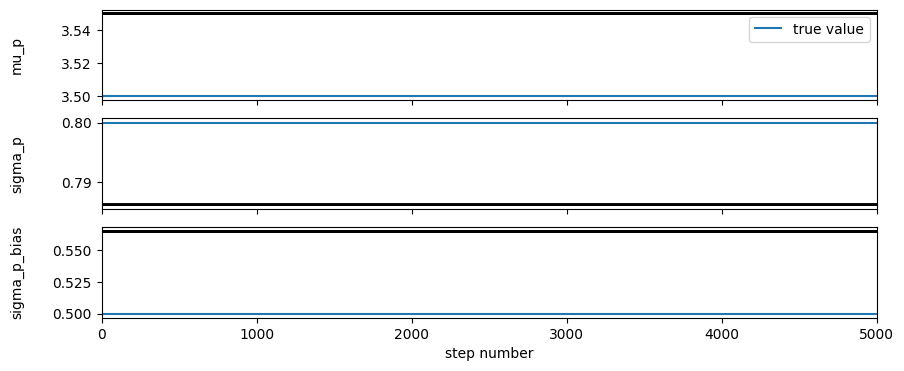

In [29]:
fig, axes = plt.subplots(3, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["mu_p", "sigma_p", "sigma_p_bias"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[0].hlines(true_parent_mean, 0, len(samples), label="true value")
axes[1].hlines(true_parent_scale, 0, len(samples))
axes[2].hlines(true_parent_scale_bias, 0, len(samples))
axes[-1].set_xlabel("step number")
axes[0].legend()

In [30]:
tau = sampler.get_autocorr_time()
print(tau)

[nan nan nan]


/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


In [31]:
flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
print(flat_samples.shape)

(16500, 3)


Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


ValueError: Provided figure has 9 axes, but data has dimensions K=2

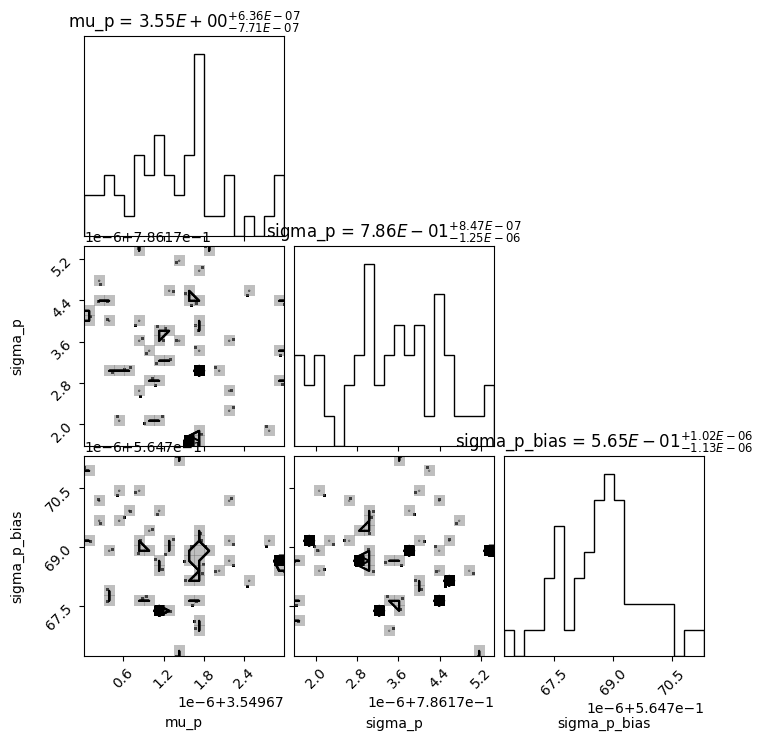

In [32]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_parent_mean, true_parent_scale], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

# BIMODAL HM (analytical calculation is not done)

In [33]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

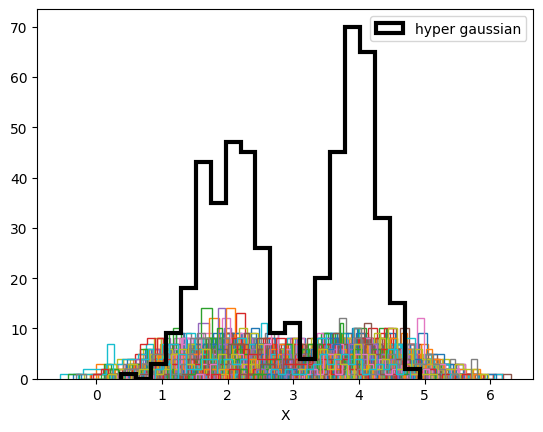

In [34]:
N_obs = 500
size_child = 50

true_parent_mean_A = 2.0 # hyperparameter
true_parent_scale_A = .5 # hyperparameter
true_parent_mean_B = 4.0 # hyperparameter
true_parent_scale_B = .3 # hyperparameter

true_child_scale = 0.5

parent_gaussian = np.concatenate((np.random.normal(loc=true_parent_mean_A, scale=true_parent_scale_A, size=N_obs//2), 
                                  np.random.normal(loc=true_parent_mean_B, scale=true_parent_scale_B, size=N_obs//2)),
                                )

# Add scatter on the child mean because the data for a signal is signal + noise
err_on_mean_child = np.expand_dims(np.random.randn(N_obs)/10, axis=1)
child_gaussian = np.random.normal(loc=parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

for i in range(N_obs):
    plt.hist(child_gaussian[i], fill=False, histtype='step', bins=20)
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian', bins=20)
plt.xlabel("X")
plt.legend()

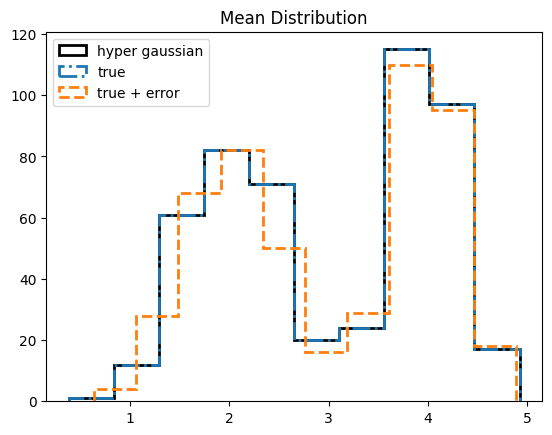

In [35]:
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=2, label='hyper gaussian')
plt.hist(parent_gaussian[:, np.newaxis], histtype='step', fill=False, label='true', linestyle='-.', linewidth=2)
plt.hist(parent_gaussian[:, np.newaxis] + err_on_mean_child, fill=False, histtype='step', label='true + error', linestyle='--', linewidth=2)
plt.title("Mean Distribution")
plt.legend()

In [36]:
posterior_child = lambda : (2 * np.pi * true_child_scale**2)**(-0.5) * np.exp(-(child_gaussian - np.expand_dims(child_gaussian.mean(axis=1), axis=1))**2 / (2 * true_child_scale**2))
model = lambda parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B : (
                                (2 * np.pi * parent_scale_A**2)**(-0.5) * np.exp(-(child_gaussian.mean(axis=1) - parent_mean_A)**2 / (2 * parent_scale_A**2)) + \
                                (2 * np.pi * parent_scale_B**2)**(-0.5) * np.exp(-(child_gaussian.mean(axis=1) - parent_mean_B)**2 / (2 * parent_scale_B**2))
                                ) * \
                                            size_child**-1 * np.sum(posterior_child(), axis=1)

def log_likelihood(params):
    parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B = params
    return np.log(np.product(model(parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B)))

In [37]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([true_parent_mean_A, true_parent_scale_A, true_parent_mean_B, true_parent_scale_B]) + 0.1 * np.random.randn(4)
soln = minimize(nll, initial)
mu_A_ml, sigma_A_ml, mu_B_ml, sigma_B_ml = soln.x
    
print("Maximum likelihood estimates:")
print("mu_A = {0:.3f}".format(mu_A_ml))
print("sigma_A = {0:.3f}".format(sigma_A_ml))
print("mu_B = {0:.3f}".format(mu_B_ml))
print("sigma_B = {0:.3f}".format(sigma_B_ml))

Maximum likelihood estimates:
mu_A = 2.025
sigma_A = 0.471
mu_B = 3.997
sigma_B = 0.332


In [38]:
def log_prior(params):
    parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B = params
    # Flat priors 
    if (0 < parent_mean_A < 5 and 
        0 < parent_scale_A < 1 and
        0 < parent_mean_B < 5 and 
        0 < parent_scale_B < 1):
        return 0.0
    return -np.inf

def log_probability(params):
    log_prior_val = log_prior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [39]:
import emcee

pos = soln.x + 1e-6 * np.random.randn(50, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)
sampler.run_mcmc(pos, 8000, progress=True)

100%|██████████| 8000/8000 [01:10<00:00, 113.42it/s]


State([[2.07875741 0.51339363 4.02398261 0.32082462]
 [2.00234228 0.45070061 3.98083174 0.33111576]
 [2.01896318 0.46305718 4.00544139 0.31818256]
 [2.01710132 0.49590642 4.00212642 0.32177426]
 [2.02167247 0.46570101 3.94920644 0.3431076 ]
 [1.99595808 0.47102701 3.98338428 0.32602945]
 [2.01153762 0.45407701 4.0010163  0.33969725]
 [2.0846294  0.54234763 3.96839762 0.32715061]
 [1.98942755 0.42675059 3.97637307 0.33952739]
 [1.99592123 0.45415315 3.98995171 0.31864094]
 [2.02693599 0.52195174 4.01307197 0.31975718]
 [1.99392219 0.49087049 4.0129427  0.33730039]
 [1.96838355 0.49339539 3.98002921 0.35268713]
 [2.01627235 0.42263404 3.99637359 0.35162957]
 [2.01688622 0.46011337 3.98747385 0.34996519]
 [2.06698671 0.46061276 3.98458257 0.34494177]
 [1.98088608 0.45694171 3.99839978 0.32099158]
 [1.99732141 0.44795371 3.99009062 0.34674731]
 [2.03801306 0.44338541 3.96518437 0.33786929]
 [2.03597341 0.47822104 3.95262563 0.36517629]
 [2.03405419 0.46227916 3.97766982 0.34000727]
 [2.000

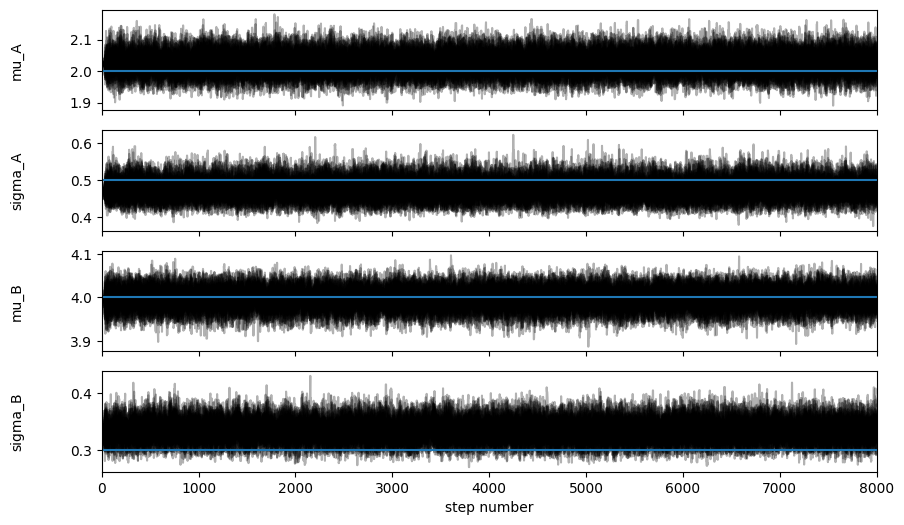

In [40]:
fig, axes = plt.subplots(4, figsize=(10, 6), sharex=True)
samples = sampler.get_chain()
labels = ["mu_A", "sigma_A", "mu_B", "sigma_B"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
axes[0].hlines(true_parent_mean_A, 0, len(samples), label="true value")
axes[1].hlines(true_parent_scale_A, 0, len(samples))
axes[2].hlines(true_parent_mean_B, 0, len(samples))
axes[3].hlines(true_parent_scale_B, 0, len(samples))

In [41]:
tau = sampler.get_autocorr_time()
print(tau)

[45.47555771 47.26823203 47.27305033 48.01993607]


In [42]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(26300, 4)


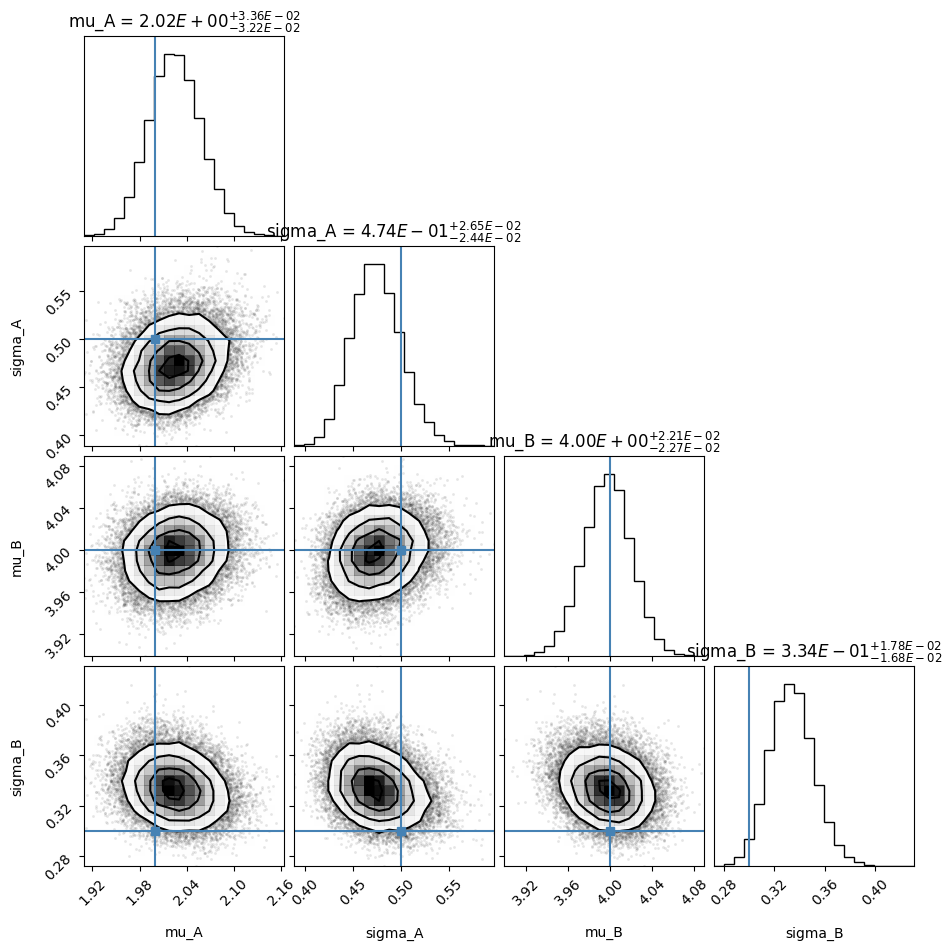

In [43]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_parent_mean_A, true_parent_scale_A, true_parent_mean_B, true_parent_scale_B], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

# Mixed Gaussian model (not working)

## method 2 N_obs = frac x N_obs

In [44]:
import numpy as np
import matplotlib.pyplot as plt

/tmp/ipykernel_19215/1765875900.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  parent_gaussian = np.concatenate((true_frac_A * np.random.normal(loc=true_parent_mean_A, scale=true_parent_scale_A, size=np.int(np.round(true_frac_A * N_obs))),
/tmp/ipykernel_19215/1765875900.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the prec

(0.0, 140.0)

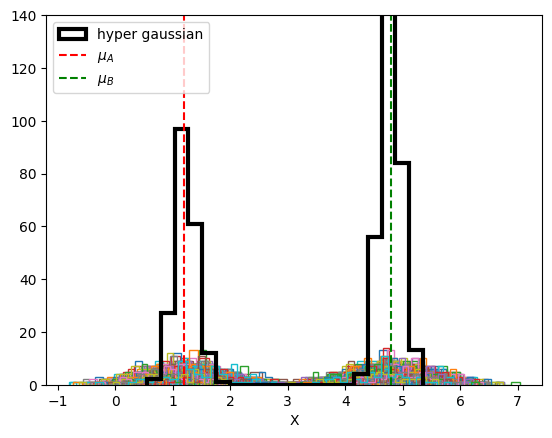

In [45]:
N_obs = 500
size_child = 50

true_frac_A = 0.4
true_parent_mean_A = 3.0 # hyperparameter
true_parent_scale_A = .5 # hyperparameter
true_parent_mean_B = 8.0 # hyperparameter
true_parent_scale_B = .3 # hyperparameter

true_child_scale = 0.5

parent_gaussian = np.concatenate((true_frac_A * np.random.normal(loc=true_parent_mean_A, scale=true_parent_scale_A, size=np.int(np.round(true_frac_A * N_obs))), 
                                  (1 - true_frac_A) * np.random.normal(loc=true_parent_mean_B, scale=true_parent_scale_B, size=np.int(np.round((1 - true_frac_A) * N_obs)))),
                                )

# Add scatter on the child mean because the data for a signal is signal + noise
err_on_mean_child = np.expand_dims(np.random.randn(N_obs)/10, axis=1)
child_gaussian = np.random.normal(loc=parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

for i in range(N_obs):
    plt.hist(child_gaussian[i], fill=False, histtype='step', bins=20)
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian', bins=20)
plt.vlines(true_parent_mean_A * true_frac_A, 0, 200, linestyles='--', color='r', label=r'$\mu_A$')
plt.vlines(true_parent_mean_B * (1 - true_frac_A), 0, 200, linestyles='--', color='g', label=r'$\mu_B$')
plt.xlabel("X")
plt.legend()
plt.ylim(0,140)

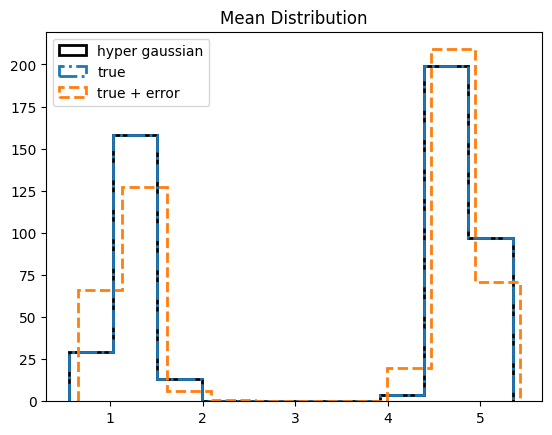

In [46]:
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=2, label='hyper gaussian')
plt.hist(parent_gaussian[:, np.newaxis], histtype='step', fill=False, label='true', linestyle='-.', linewidth=2)
plt.hist(parent_gaussian[:, np.newaxis] + err_on_mean_child, fill=False, histtype='step', label='true + error', linestyle='--', linewidth=2)
plt.title("Mean Distribution")
plt.legend()

In [47]:
posterior_child = lambda : (2 * np.pi * true_child_scale**2)**(-0.5) * np.exp(-(child_gaussian - np.expand_dims(child_gaussian.mean(axis=1), axis=1))**2 / (2 * true_child_scale**2))
model = lambda frac_A, parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B : (
                                frac_A * (2 * np.pi * parent_scale_A**2)**(-0.5) * np.exp(-(child_gaussian.mean(axis=1) - parent_mean_A)**2 / (2 * parent_scale_A**2)) + \
                                (1 - frac_A) * (2 * np.pi * parent_scale_B**2)**(-0.5) * np.exp(-(child_gaussian.mean(axis=1) - parent_mean_B)**2 / (2 * parent_scale_B**2))
                                ) * size_child**-1 * np.sum(posterior_child(), axis=1)

def log_likelihood(params):
    frac_A, parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B = params
    return np.log(np.product(model(frac_A, parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B)))

In [48]:
from scipy.optimize import minimize

np.random.seed(500)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([true_frac_A, true_parent_mean_A, true_parent_scale_A, true_parent_mean_B, true_parent_scale_B]) + 0.1 * np.random.randn(5)
soln = minimize(nll, initial)
frac_A_ml, mu_A_ml, sigma_A_ml, mu_B_ml, sigma_B_ml = soln.x
    
print("Maximum likelihood estimates:")
print("frac_A = {0:.3f}".format(frac_A_ml))
print("mu_A = {0:.3f}".format(mu_A_ml))
print("sigma_A = {0:.3f}".format(sigma_A_ml))
print("mu_B = {0:.3f}".format(mu_B_ml))
print("sigma_B = {0:.3f}".format(sigma_B_ml))

Maximum likelihood estimates:
frac_A = 0.362
mu_A = 3.017
sigma_A = 0.568
mu_B = 8.192
sigma_B = 0.280


/tmp/ipykernel_19215/1647262016.py:9: RuntimeWarning: divide by zero encountered in log
  return np.log(np.product(model(frac_A, parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B)))
/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [49]:
def log_prior(params):
    frac_A, parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B = params
    # Flat priors 
    if (0 < frac_A < 1 and
        0 < parent_mean_A < 5 and 
        0 < parent_scale_A < 1 and
        5 < parent_mean_B < 10 and 
        0 < parent_scale_B < 1):
        return 0.0
    return -np.inf

def log_probability(params):
    log_prior_val = log_prior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [50]:
import emcee

pos = soln.x + 1e-6 * np.random.randn(50, 5)
nwalkers, ndim = pos.shape

from multiprocessing import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, pool=pool
    )
    sampler.run_mcmc(pos, 5000, progress=True)

/tmp/ipykernel_19215/1647262016.py:9: RuntimeWarning: divide by zero encountered in log
  return np.log(np.product(model(frac_A, parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B)))
/tmp/ipykernel_19215/1647262016.py:9: RuntimeWarning: divide by zero encountered in log
  return np.log(np.product(model(frac_A, parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B)))
/tmp/ipykernel_19215/1647262016.py:9: RuntimeWarning: divide by zero encountered in log
  return np.log(np.product(model(frac_A, parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B)))
/tmp/ipykernel_19215/1647262016.py:9: RuntimeWarning: divide by zero encountered in log
  return np.log(np.product(model(frac_A, parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B)))
/tmp/ipykernel_19215/1647262016.py:9: RuntimeWarning: divide by zero encountered in log
  return np.log(np.product(model(frac_A, parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B)))
/tmp/ipykernel_19215/1647262016.py:

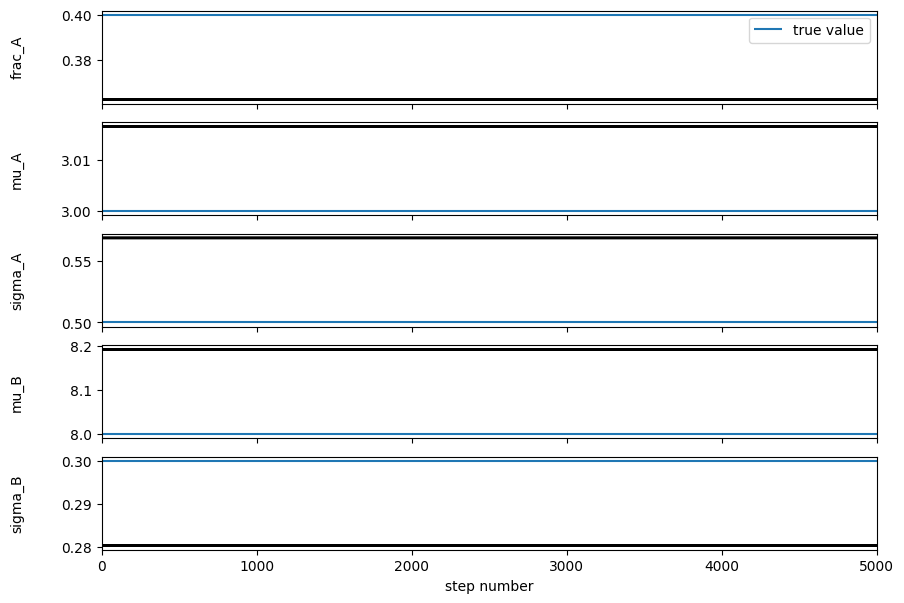

In [51]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["frac_A", "mu_A", "sigma_A", "mu_B", "sigma_B"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
axes[0].hlines(true_frac_A, 0, len(samples), label="true value")
axes[1].hlines(true_parent_mean_A, 0, len(samples))
axes[2].hlines(true_parent_scale_A, 0, len(samples))
axes[3].hlines(true_parent_mean_B, 0, len(samples))
axes[4].hlines(true_parent_scale_B, 0, len(samples))
axes[0].legend()

In [52]:
tau = sampler.get_autocorr_time()
print(tau)

[nan nan nan nan nan]


/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


In [53]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(16300, 5)


Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


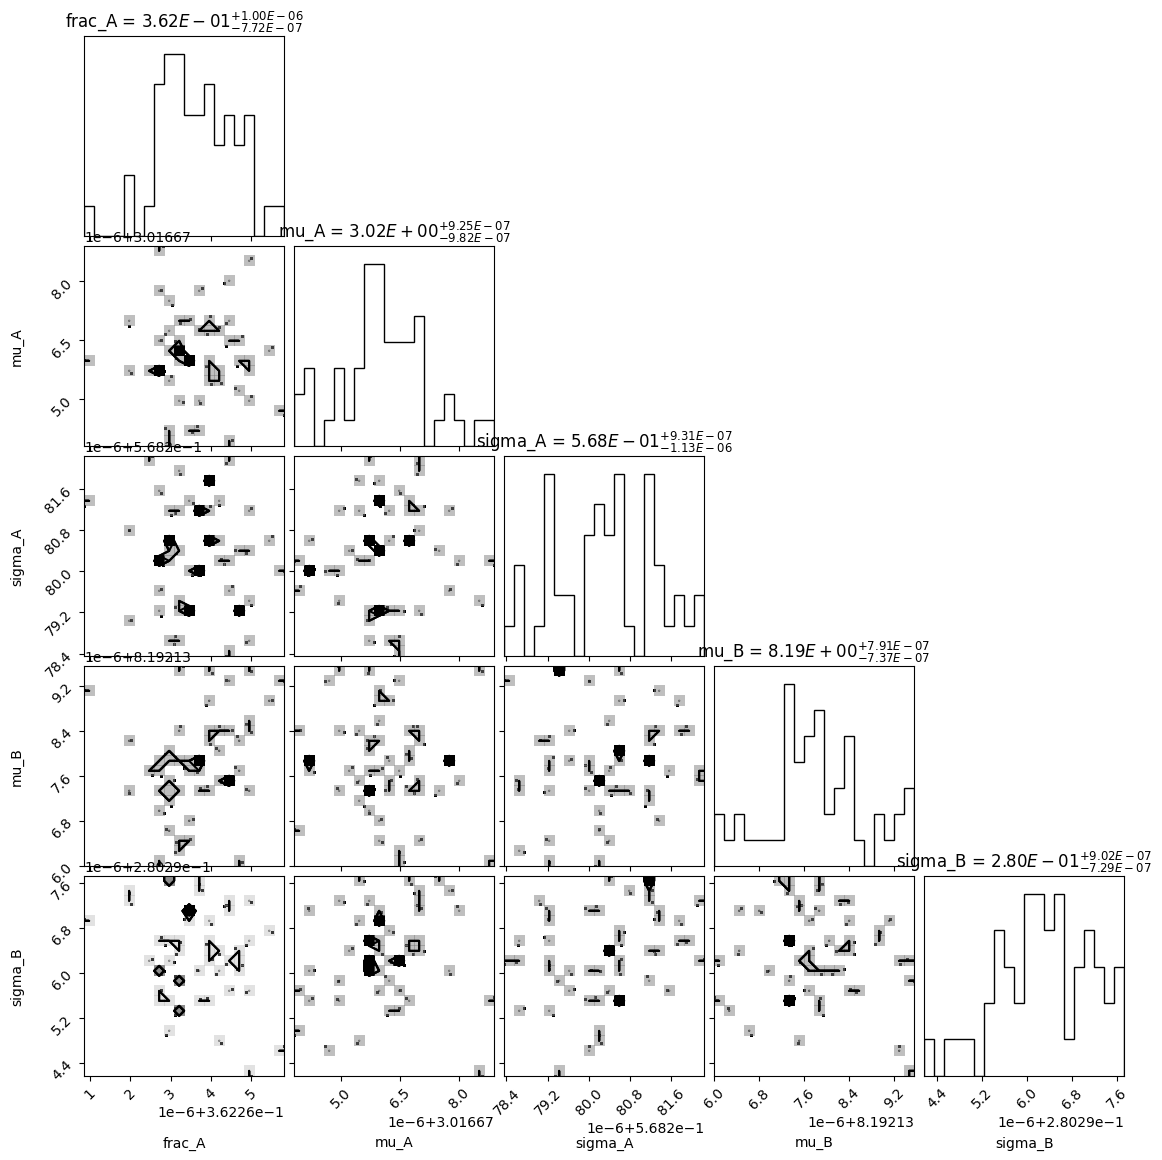

In [54]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_frac_A, true_parent_mean_A, true_parent_scale_A, true_parent_mean_B, true_parent_scale_B], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)